# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">LightGBM</p></div> 

- **Training** 
    - Train-Test Split
    - Cross Validation
- **Hypertuning**
     - Optuna
     - Trade-Off Bias/Variance
     - Save Model

# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Training</p></div> 

In [3]:
%%capture
%run part03_preparation.ipynb

In [4]:
#Visualization Tools
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# Machine Learning Models
from lightgbm import LGBMClassifier

# Model Selection Tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
import optuna

# Model Evaluation Tools
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report

import pickle
from datetime import datetime

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [5]:
X.shape, y.shape

((87245, 19), (87245,))

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, shuffle=True, random_state=RANDOM_SEED)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((69796, 19), (69796,), (17449, 19), (17449,))

In [7]:
def CM(y, y_pred):
    labels = ["Não Cancelado", "Cancelado"]
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")  
    plt.show()
    print("Score: \n", classification_report(y,y_pred))   

In [8]:
def ROC(model, y, y_prob, model_dict):
    score_metrics_auc = pd.DataFrame(columns=['Model','AUC']) 
    fpr,tpr, threshold = roc_curve(y,y_prob)
    auc = roc_auc_score(y,y_prob)
    plt.figure(figsize=(4, 3))
    plt.plot(fpr,tpr, color='steelblue', label = model_dict)    
    plt.title("ROC")
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.plot([0,1],[0,1], color='black', linestyle='--')
    plt.xlabel("False Positives Rate (1- Specifity)")
    plt.ylabel("True Positives Rate (Sensitivity)")
    plt.legend(loc = 'lower right') 
    plt.show()
    #print(f"AUC: {auc:.4f}\n\n")     
   
    return y_prob, auc

In [9]:
def CVS(model, X, y, model_dict=''):
   
    number_folds = 5    
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True, random_state=RANDOM_SEED )
    
    y_prob = cross_val_predict(model, X, y, cv=Kfold, method='predict_proba', verbose=False)    
    y_prob = y_prob[:,1]
    
    ### Defining threshold ###
    y_pred = np.empty(shape=(len(y_prob)))
    threshold = 0.5
    for i in range(len(y_prob)):    
        if y_prob[i] >= threshold:
            y_pred[i] = 1  
        else:
            y_pred[i] = 0  
   
    CM(y,y_pred)
    ROC(model, y, y_prob, model_dict) 
  
    scores = cross_validate(model, X, y, cv = Kfold, scoring=['accuracy','precision','recall','f1','roc_auc'], return_train_score=True)
    
    df = pd.DataFrame.from_dict(scores).T
    df['value'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)
    display(df[['value','std']])    
    
    return y_prob, y_pred

In [10]:
lgbm_model = LGBMClassifier(random_state=RANDOM_SEED)

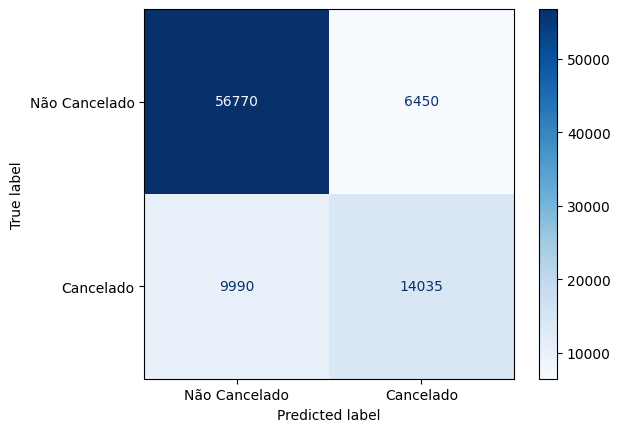

Score: 
               precision    recall  f1-score   support

           0       0.85      0.90      0.87     63220
           1       0.69      0.58      0.63     24025

    accuracy                           0.81     87245
   macro avg       0.77      0.74      0.75     87245
weighted avg       0.80      0.81      0.81     87245



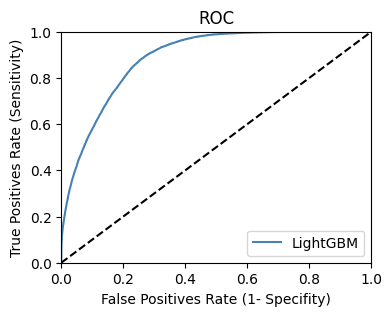

,value,std
fit_time,0.149665,0.008153
score_time,0.031058,0.001307
test_accuracy,0.811565,0.001204
train_accuracy,0.822546,0.000486
test_precision,0.685157,0.003314
train_precision,0.708601,0.002625
test_recall,0.584183,0.004580
train_recall,0.604027,0.006805
test_f1,0.630638,0.002742
train_f1,0.652113,0.002996


In [11]:
lgbm_y_prob, lgbm_y_pred  = CVS(lgbm_model,X,y,'LightGBM')

# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Hypertuning</p></div> 

In [12]:
def objective(trial):
    
    weight = round(float((y.value_counts()[0])/(y.value_counts()[1])),3) #sum_neg/sum_p
    
    param_grid = {
        'objective': trial.suggest_categorical('objective', ['binary']),        
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt','dart']), 
        "num_leaves": trial.suggest_int("num_leaves", 100, 300, step=20),
        "max_depth": trial.suggest_int("max_depth", 6, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 1.0, log=True),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 10),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1,weight]),
        #'metric': trial.suggest_categorical('metric', ['auc']), 
        #'eval_metric': trial.suggest_categorical('eval_metric', ['f1']),   
        #"metric": "binary_error",
        #'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 0.9),
        #'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 0.9),
        #'is_unbalance': trial.suggest_categorical('is_unbalance', [False,True]),
        #'boost_from_average': trial.suggest_categorical('boost_from_average', [False,True]),
        #'early_stopping_rounds':10,
        #'verbosity':0,
        'seed': RANDOM_SEED
    }
    
    model = LGBMClassifier(**param_grid)
    
    number_folds = 3
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True)#random_state=RANDOM_SEED
    #scores = cross_val_score(model, X, y, cv=Kfold, scoring="precision")
    #return scores.mean()
    y_pred = cross_val_predict(model, X, y, cv=Kfold)
    return f1_score(y,y_pred)   

In [13]:
study = optuna.create_study(direction='maximize')
#optuna.logging.set_verbosity(optuna.logging.WARNING) 
#optuna.logging.set_verbosity(optuna.logging.DEBUG) 
study.optimize(objective, n_trials=500);

trial = study.best_trial

[I 2023-06-15 15:11:55,022] A new study created in memory with name: no-name-4ddb6b2e-19a5-4972-83a6-f381f13a8233
[I 2023-06-15 15:11:56,240] Trial 0 finished with value: 0.0 and parameters: {'objective': 'binary', 'boosting_type': 'dart', 'num_leaves': 140, 'max_depth': 7, 'learning_rate': 0.0011357188977972551, 'reg_alpha': 0.043221408319669884, 'reg_lambda': 0.0002616186360491653, 'subsample_freq': 10, 'min_child_samples': 3, 'scale_pos_weight': 2.631}. Best is trial 0 with value: 0.0.
[I 2023-06-15 15:11:56,851] Trial 1 finished with value: 0.6694472394430199 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 120, 'max_depth': 7, 'learning_rate': 0.014954863787183062, 'reg_alpha': 0.017601251623534927, 'reg_lambda': 1.454308543035998e-06, 'subsample_freq': 7, 'min_child_samples': 6, 'scale_pos_weight': 2.631}. Best is trial 1 with value: 0.6694472394430199.
[I 2023-06-15 15:11:57,878] Trial 2 finished with value: 0.6752686077839453 and parameters: {'obje

[I 2023-06-15 15:12:30,686] Trial 20 finished with value: 0.6876152854181289 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 200, 'max_depth': 13, 'learning_rate': 0.025736022563039813, 'reg_alpha': 0.001744959948592408, 'reg_lambda': 0.0006428297601452437, 'subsample_freq': 7, 'min_child_samples': 1, 'scale_pos_weight': 2.631}. Best is trial 16 with value: 0.6942347518204288.
[I 2023-06-15 15:12:32,188] Trial 21 finished with value: 0.691256294552351 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 11, 'learning_rate': 0.06229894825449735, 'reg_alpha': 0.3476743205600371, 'reg_lambda': 0.0025255684953520902, 'subsample_freq': 7, 'min_child_samples': 4, 'scale_pos_weight': 2.631}. Best is trial 16 with value: 0.6942347518204288.
[I 2023-06-15 15:12:34,081] Trial 22 finished with value: 0.6911815110414729 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 11, 'lea

[I 2023-06-15 15:13:05,859] Trial 40 finished with value: 0.6936414274144229 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 300, 'max_depth': 14, 'learning_rate': 0.05055821832355666, 'reg_alpha': 0.036512975450878025, 'reg_lambda': 0.00035997713484740347, 'subsample_freq': 3, 'min_child_samples': 3, 'scale_pos_weight': 2.631}. Best is trial 34 with value: 0.6956812967831606.
[I 2023-06-15 15:13:07,206] Trial 41 finished with value: 0.6943697952954447 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 240, 'max_depth': 13, 'learning_rate': 0.07792414177071674, 'reg_alpha': 0.3372853517551184, 'reg_lambda': 0.00029876506853014954, 'subsample_freq': 2, 'min_child_samples': 4, 'scale_pos_weight': 2.631}. Best is trial 34 with value: 0.6956812967831606.
[I 2023-06-15 15:13:08,549] Trial 42 finished with value: 0.6940428569057381 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 240, 'max_depth': 13, 'l

[I 2023-06-15 15:13:36,990] Trial 60 finished with value: 0.6873673556012668 and parameters: {'objective': 'binary', 'boosting_type': 'dart', 'num_leaves': 300, 'max_depth': 14, 'learning_rate': 0.04917360648943968, 'reg_alpha': 0.9603246567626976, 'reg_lambda': 4.019077666560696e-05, 'subsample_freq': 2, 'min_child_samples': 9, 'scale_pos_weight': 2.631}. Best is trial 34 with value: 0.6956812967831606.
[I 2023-06-15 15:13:38,497] Trial 61 finished with value: 0.6937072387870598 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 14, 'learning_rate': 0.09842776052930287, 'reg_alpha': 0.140475911358223, 'reg_lambda': 0.00010547286138704017, 'subsample_freq': 2, 'min_child_samples': 2, 'scale_pos_weight': 2.631}. Best is trial 34 with value: 0.6956812967831606.
[I 2023-06-15 15:13:39,561] Trial 62 finished with value: 0.6941807946586371 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 140, 'max_depth': 15, 'learn

[I 2023-06-15 15:14:06,156] Trial 80 finished with value: 0.6953909822113941 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 14, 'learning_rate': 0.07415387220388181, 'reg_alpha': 0.9034310337645606, 'reg_lambda': 0.00017040066676117808, 'subsample_freq': 1, 'min_child_samples': 2, 'scale_pos_weight': 2.631}. Best is trial 34 with value: 0.6956812967831606.
[I 2023-06-15 15:14:07,748] Trial 81 finished with value: 0.6942261815391289 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 14, 'learning_rate': 0.07540711520081167, 'reg_alpha': 0.829419772021103, 'reg_lambda': 0.0002023153915600855, 'subsample_freq': 1, 'min_child_samples': 2, 'scale_pos_weight': 2.631}. Best is trial 34 with value: 0.6956812967831606.
[I 2023-06-15 15:14:09,218] Trial 82 finished with value: 0.6931637519872814 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 14, 'learn

[I 2023-06-15 15:14:43,359] Trial 100 finished with value: 0.6931731439381368 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 300, 'max_depth': 15, 'learning_rate': 0.05844882515876992, 'reg_alpha': 0.6808971689277691, 'reg_lambda': 0.00034204071191333503, 'subsample_freq': 3, 'min_child_samples': 2, 'scale_pos_weight': 2.631}. Best is trial 89 with value: 0.6957227847471953.
[I 2023-06-15 15:14:44,874] Trial 101 finished with value: 0.6926179844292094 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 15, 'learning_rate': 0.06401913954547646, 'reg_alpha': 0.6293718264604816, 'reg_lambda': 3.3391397294677116e-05, 'subsample_freq': 4, 'min_child_samples': 5, 'scale_pos_weight': 2.631}. Best is trial 89 with value: 0.6957227847471953.
[I 2023-06-15 15:14:46,422] Trial 102 finished with value: 0.6948031496062992 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 15, '

[I 2023-06-15 15:15:14,757] Trial 120 finished with value: 0.6943580704700777 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 14, 'learning_rate': 0.06950263870679552, 'reg_alpha': 0.08014237409099013, 'reg_lambda': 0.00019323391680826454, 'subsample_freq': 2, 'min_child_samples': 3, 'scale_pos_weight': 2.631}. Best is trial 118 with value: 0.6961538461538461.
[I 2023-06-15 15:15:16,266] Trial 121 finished with value: 0.693676854424518 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 15, 'learning_rate': 0.09285210199179264, 'reg_alpha': 0.15811619291716394, 'reg_lambda': 7.019320308033717e-05, 'subsample_freq': 1, 'min_child_samples': 1, 'scale_pos_weight': 2.631}. Best is trial 118 with value: 0.6961538461538461.
[I 2023-06-15 15:15:17,649] Trial 122 finished with value: 0.6924565442231342 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 240, 'max_depth': 14,

[I 2023-06-15 15:15:50,207] Trial 140 finished with value: 0.696325343970792 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 300, 'max_depth': 14, 'learning_rate': 0.0996241670776688, 'reg_alpha': 0.2995718493897094, 'reg_lambda': 0.00016578394596810078, 'subsample_freq': 1, 'min_child_samples': 3, 'scale_pos_weight': 2.631}. Best is trial 140 with value: 0.696325343970792.
[I 2023-06-15 15:15:51,980] Trial 141 finished with value: 0.6935025380710661 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 300, 'max_depth': 14, 'learning_rate': 0.09996849708062028, 'reg_alpha': 0.31305944380945855, 'reg_lambda': 0.00015744065181403467, 'subsample_freq': 1, 'min_child_samples': 3, 'scale_pos_weight': 2.631}. Best is trial 140 with value: 0.696325343970792.
[I 2023-06-15 15:15:54,078] Trial 142 finished with value: 0.6958788729569838 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 300, 'max_depth': 14, 'l

[I 2023-06-15 15:16:33,767] Trial 160 finished with value: 0.6964306631637075 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 13, 'learning_rate': 0.09095805292794969, 'reg_alpha': 0.7173730242079894, 'reg_lambda': 0.0003278336322795674, 'subsample_freq': 1, 'min_child_samples': 7, 'scale_pos_weight': 2.631}. Best is trial 160 with value: 0.6964306631637075.
[I 2023-06-15 15:16:35,690] Trial 161 finished with value: 0.694538391990088 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 13, 'learning_rate': 0.09213909060871277, 'reg_alpha': 0.7765203359264016, 'reg_lambda': 0.00035693804790220396, 'subsample_freq': 1, 'min_child_samples': 7, 'scale_pos_weight': 2.631}. Best is trial 160 with value: 0.6964306631637075.
[I 2023-06-15 15:16:37,917] Trial 162 finished with value: 0.689315838800375 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 14, 'l

[I 2023-06-15 15:17:11,548] Trial 180 finished with value: 0.6853188139595906 and parameters: {'objective': 'binary', 'boosting_type': 'dart', 'num_leaves': 260, 'max_depth': 14, 'learning_rate': 0.029065705276704178, 'reg_alpha': 0.011691645552632232, 'reg_lambda': 0.003036457430406504, 'subsample_freq': 1, 'min_child_samples': 5, 'scale_pos_weight': 2.631}. Best is trial 160 with value: 0.6964306631637075.
[I 2023-06-15 15:17:13,267] Trial 181 finished with value: 0.6967849408629019 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 240, 'max_depth': 14, 'learning_rate': 0.08474863947805296, 'reg_alpha': 0.5563548970847082, 'reg_lambda': 0.000469640073561878, 'subsample_freq': 1, 'min_child_samples': 6, 'scale_pos_weight': 2.631}. Best is trial 181 with value: 0.6967849408629019.
[I 2023-06-15 15:17:14,997] Trial 182 finished with value: 0.6955320282327873 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 240, 'max_depth': 14, 

[I 2023-06-15 15:17:54,862] Trial 200 finished with value: 0.6947315604616155 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 240, 'max_depth': 14, 'learning_rate': 0.09275925702017988, 'reg_alpha': 0.5139942370659435, 'reg_lambda': 0.0006503509212696398, 'subsample_freq': 1, 'min_child_samples': 6, 'scale_pos_weight': 2.631}. Best is trial 181 with value: 0.6967849408629019.
[I 2023-06-15 15:17:55,572] Trial 201 finished with value: 0.6866349063284619 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 240, 'max_depth': 8, 'learning_rate': 0.08510336553631397, 'reg_alpha': 0.4369310651564536, 'reg_lambda': 0.001411767342658403, 'subsample_freq': 1, 'min_child_samples': 6, 'scale_pos_weight': 2.631}. Best is trial 181 with value: 0.6967849408629019.
[I 2023-06-15 15:17:57,371] Trial 202 finished with value: 0.6942492757483932 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 240, 'max_depth': 14, 'le

[I 2023-06-15 15:19:08,523] Trial 220 finished with value: 0.6951949710570401 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 15, 'learning_rate': 0.061952537747202725, 'reg_alpha': 0.0021142270101459637, 'reg_lambda': 0.0004205691342449746, 'subsample_freq': 1, 'min_child_samples': 5, 'scale_pos_weight': 2.631}. Best is trial 181 with value: 0.6967849408629019.
[I 2023-06-15 15:19:10,535] Trial 221 finished with value: 0.6956550713048114 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 15, 'learning_rate': 0.07515455654042454, 'reg_alpha': 0.001986521175807448, 'reg_lambda': 0.0001280919551405128, 'subsample_freq': 1, 'min_child_samples': 5, 'scale_pos_weight': 2.631}. Best is trial 181 with value: 0.6967849408629019.
[I 2023-06-15 15:19:12,806] Trial 222 finished with value: 0.6955059920106524 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth':

[I 2023-06-15 15:19:48,574] Trial 240 finished with value: 0.693844608061142 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 240, 'max_depth': 14, 'learning_rate': 0.06107738924419148, 'reg_alpha': 0.46361353146124157, 'reg_lambda': 0.0026561605299743004, 'subsample_freq': 2, 'min_child_samples': 5, 'scale_pos_weight': 2.631}. Best is trial 181 with value: 0.6967849408629019.
[I 2023-06-15 15:19:50,456] Trial 241 finished with value: 0.6934733683420854 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 240, 'max_depth': 14, 'learning_rate': 0.0826010024722336, 'reg_alpha': 0.7812291157416935, 'reg_lambda': 0.0004563401095002995, 'subsample_freq': 1, 'min_child_samples': 6, 'scale_pos_weight': 2.631}. Best is trial 181 with value: 0.6967849408629019.
[I 2023-06-15 15:19:52,390] Trial 242 finished with value: 0.6952811078271843 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 240, 'max_depth': 14, 'l

[I 2023-06-15 15:20:23,914] Trial 260 finished with value: 0.6426458486243634 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 14, 'learning_rate': 0.09380392099463307, 'reg_alpha': 0.0007026667910140865, 'reg_lambda': 0.00010288499747421526, 'subsample_freq': 1, 'min_child_samples': 5, 'scale_pos_weight': 1}. Best is trial 181 with value: 0.6967849408629019.
[I 2023-06-15 15:20:25,885] Trial 261 finished with value: 0.6943781600947819 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 300, 'max_depth': 14, 'learning_rate': 0.06943824208680015, 'reg_alpha': 0.0020959059946730517, 'reg_lambda': 0.0005992442376064465, 'subsample_freq': 1, 'min_child_samples': 3, 'scale_pos_weight': 2.631}. Best is trial 181 with value: 0.6967849408629019.
[I 2023-06-15 15:20:27,949] Trial 262 finished with value: 0.692679876242512 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 240, 'max_depth': 13,

[I 2023-06-15 15:21:06,808] Trial 280 finished with value: 0.6923595912389541 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 15, 'learning_rate': 0.04212377241122401, 'reg_alpha': 0.004079461040840696, 'reg_lambda': 0.0006328517558305578, 'subsample_freq': 2, 'min_child_samples': 7, 'scale_pos_weight': 2.631}. Best is trial 181 with value: 0.6967849408629019.
[I 2023-06-15 15:21:09,871] Trial 281 finished with value: 0.6405363128491619 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 15, 'learning_rate': 0.05758365993912552, 'reg_alpha': 0.0032038296857593456, 'reg_lambda': 0.0003317077629328255, 'subsample_freq': 6, 'min_child_samples': 5, 'scale_pos_weight': 1}. Best is trial 181 with value: 0.6967849408629019.
[I 2023-06-15 15:21:15,417] Trial 282 finished with value: 0.696375776500681 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 15, '

[I 2023-06-15 15:23:05,162] Trial 300 finished with value: 0.6947644065830253 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 180, 'max_depth': 13, 'learning_rate': 0.09411307957279696, 'reg_alpha': 0.706522270847697, 'reg_lambda': 2.3258291673185607e-05, 'subsample_freq': 1, 'min_child_samples': 6, 'scale_pos_weight': 2.631}. Best is trial 181 with value: 0.6967849408629019.
[I 2023-06-15 15:23:06,709] Trial 301 finished with value: 0.6953743203680468 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 15, 'learning_rate': 0.08113615322367482, 'reg_alpha': 0.0010913639357433152, 'reg_lambda': 0.0001611215478377138, 'subsample_freq': 1, 'min_child_samples': 6, 'scale_pos_weight': 2.631}. Best is trial 181 with value: 0.6967849408629019.
[I 2023-06-15 15:23:08,401] Trial 302 finished with value: 0.69152598204727 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 15, 

[I 2023-06-15 15:23:38,895] Trial 320 finished with value: 0.4586036316241594 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15, 'learning_rate': 0.009100008378151158, 'reg_alpha': 0.0008489294714240759, 'reg_lambda': 0.00011793632861489909, 'subsample_freq': 7, 'min_child_samples': 3, 'scale_pos_weight': 1}. Best is trial 181 with value: 0.6967849408629019.
[I 2023-06-15 15:23:41,124] Trial 321 finished with value: 0.6943441838601909 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 14, 'learning_rate': 0.08557090264339415, 'reg_alpha': 0.0017278149254518326, 'reg_lambda': 0.00016171300094016943, 'subsample_freq': 2, 'min_child_samples': 3, 'scale_pos_weight': 2.631}. Best is trial 181 with value: 0.6967849408629019.
[I 2023-06-15 15:23:43,847] Trial 322 finished with value: 0.6951127756692137 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 

[I 2023-06-15 15:24:12,854] Trial 340 finished with value: 0.6936087412064063 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 220, 'max_depth': 13, 'learning_rate': 0.09115708620677229, 'reg_alpha': 0.005909100656032594, 'reg_lambda': 0.014208133048558539, 'subsample_freq': 3, 'min_child_samples': 4, 'scale_pos_weight': 2.631}. Best is trial 181 with value: 0.6967849408629019.
[I 2023-06-15 15:24:14,422] Trial 341 finished with value: 0.694336084648998 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 300, 'max_depth': 14, 'learning_rate': 0.07589543341481225, 'reg_alpha': 0.00019047136614167126, 'reg_lambda': 0.0002595941484047627, 'subsample_freq': 2, 'min_child_samples': 6, 'scale_pos_weight': 2.631}. Best is trial 181 with value: 0.6967849408629019.
[I 2023-06-15 15:24:16,014] Trial 342 finished with value: 0.6944660563823272 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 1

[I 2023-06-15 15:24:46,103] Trial 360 finished with value: 0.6937724827563447 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 240, 'max_depth': 14, 'learning_rate': 0.05923093192524667, 'reg_alpha': 0.3968958303869815, 'reg_lambda': 0.0018296828060258685, 'subsample_freq': 9, 'min_child_samples': 6, 'scale_pos_weight': 2.631}. Best is trial 181 with value: 0.6967849408629019.
[I 2023-06-15 15:24:48,391] Trial 361 finished with value: 0.6867697566266249 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 13, 'learning_rate': 0.019522673956084154, 'reg_alpha': 0.00034862942534951585, 'reg_lambda': 8.054208666543259e-06, 'subsample_freq': 3, 'min_child_samples': 6, 'scale_pos_weight': 2.631}. Best is trial 181 with value: 0.6967849408629019.
[I 2023-06-15 15:24:49,742] Trial 362 finished with value: 0.6942704555943826 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 240, 'max_depth': 

[I 2023-06-15 15:25:22,122] Trial 380 finished with value: 0.6955043823107941 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 240, 'max_depth': 14, 'learning_rate': 0.07875727020691496, 'reg_alpha': 0.00013802663058051974, 'reg_lambda': 0.0003853095303138951, 'subsample_freq': 1, 'min_child_samples': 6, 'scale_pos_weight': 2.631}. Best is trial 181 with value: 0.6967849408629019.
[I 2023-06-15 15:25:23,739] Trial 381 finished with value: 0.6292699843939658 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 13, 'learning_rate': 0.007164613869612772, 'reg_alpha': 0.0014085733276949246, 'reg_lambda': 0.0005808053718078989, 'subsample_freq': 1, 'min_child_samples': 6, 'scale_pos_weight': 2.631}. Best is trial 181 with value: 0.6967849408629019.
[I 2023-06-15 15:25:25,207] Trial 382 finished with value: 0.6934269283372057 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 220, 'max_depth

[I 2023-06-15 15:26:00,814] Trial 400 finished with value: 0.6942939538915468 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 12, 'learning_rate': 0.08629718872986628, 'reg_alpha': 0.0012859944102919763, 'reg_lambda': 0.00010800661299555732, 'subsample_freq': 10, 'min_child_samples': 6, 'scale_pos_weight': 2.631}. Best is trial 181 with value: 0.6967849408629019.
[I 2023-06-15 15:26:03,710] Trial 401 finished with value: 0.6949318873604897 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 15, 'learning_rate': 0.07012942227370261, 'reg_alpha': 0.0004362730197178959, 'reg_lambda': 0.02197470962408439, 'subsample_freq': 1, 'min_child_samples': 6, 'scale_pos_weight': 2.631}. Best is trial 181 with value: 0.6967849408629019.
[I 2023-06-15 15:26:06,525] Trial 402 finished with value: 0.0 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15, 'learning_

[I 2023-06-15 15:26:38,953] Trial 420 finished with value: 0.13465484532889388 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 14, 'learning_rate': 0.004524656241605196, 'reg_alpha': 5.790715884560732e-07, 'reg_lambda': 0.005134386131394335, 'subsample_freq': 1, 'min_child_samples': 8, 'scale_pos_weight': 1}. Best is trial 181 with value: 0.6967849408629019.
[I 2023-06-15 15:26:40,566] Trial 421 finished with value: 0.6944944944944944 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15, 'learning_rate': 0.07538560838402647, 'reg_alpha': 0.007501752365460214, 'reg_lambda': 0.21658546829696998, 'subsample_freq': 1, 'min_child_samples': 6, 'scale_pos_weight': 2.631}. Best is trial 181 with value: 0.6967849408629019.
[I 2023-06-15 15:26:42,153] Trial 422 finished with value: 0.6849981036444505 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 220, 'max_depth': 14, '

[I 2023-06-15 15:27:10,556] Trial 440 finished with value: 0.6950326141495233 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 13, 'learning_rate': 0.09006958541634046, 'reg_alpha': 0.6703009457227422, 'reg_lambda': 0.020021745692324244, 'subsample_freq': 1, 'min_child_samples': 6, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:27:12,328] Trial 441 finished with value: 0.690296606688029 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 300, 'max_depth': 14, 'learning_rate': 0.028474045820259662, 'reg_alpha': 0.2020008420101057, 'reg_lambda': 0.007742804586793995, 'subsample_freq': 1, 'min_child_samples': 6, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:27:14,139] Trial 442 finished with value: 0.6928406466512702 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 300, 'max_depth': 15, 'le

[I 2023-06-15 15:27:46,408] Trial 460 finished with value: 0.6953155245838173 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15, 'learning_rate': 0.08935642736655829, 'reg_alpha': 0.5036407594454079, 'reg_lambda': 0.004478948785337515, 'subsample_freq': 10, 'min_child_samples': 3, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:27:48,065] Trial 461 finished with value: 0.6928905313960749 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15, 'learning_rate': 0.09288638330173896, 'reg_alpha': 0.3736703112721434, 'reg_lambda': 0.0035160048477475944, 'subsample_freq': 10, 'min_child_samples': 3, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:27:49,778] Trial 462 finished with value: 0.6954731821604887 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15, 

[I 2023-06-15 15:28:28,022] Trial 480 finished with value: 0.6964608282598514 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15, 'learning_rate': 0.07968666287213055, 'reg_alpha': 0.43581780916910334, 'reg_lambda': 0.156492823653979, 'subsample_freq': 9, 'min_child_samples': 2, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:28:33,267] Trial 481 finished with value: 0.6925293507434424 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15, 'learning_rate': 0.036467577806993695, 'reg_alpha': 0.39038620730122103, 'reg_lambda': 1.0481838949822681e-06, 'subsample_freq': 9, 'min_child_samples': 1, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:28:35,933] Trial 482 finished with value: 0.6955972752948995 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15, '

[I 2023-06-15 15:29:17,958] Trial 500 finished with value: 0.5242661395870616 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15, 'learning_rate': 0.005822943842590581, 'reg_alpha': 6.129548103617194e-08, 'reg_lambda': 0.659603864272042, 'subsample_freq': 9, 'min_child_samples': 2, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:29:19,625] Trial 501 finished with value: 0.6947730766659982 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 15, 'learning_rate': 0.07616331179104663, 'reg_alpha': 0.004089955581469976, 'reg_lambda': 0.011703620377522383, 'subsample_freq': 9, 'min_child_samples': 2, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:29:20,637] Trial 502 finished with value: 0.6897412619155696 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 240, 'max_depth': 9, '

[I 2023-06-15 15:29:53,186] Trial 520 finished with value: 8.324315325064514e-05 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 240, 'max_depth': 15, 'learning_rate': 0.0035928310764501447, 'reg_alpha': 0.00022555549359438924, 'reg_lambda': 0.0015565073511320787, 'subsample_freq': 9, 'min_child_samples': 4, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:29:54,959] Trial 521 finished with value: 0.6886006328379968 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 240, 'max_depth': 13, 'learning_rate': 0.016601279067158144, 'reg_alpha': 0.0003058647114138157, 'reg_lambda': 0.8441750465630129, 'subsample_freq': 9, 'min_child_samples': 4, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:29:56,880] Trial 522 finished with value: 0.371111468553965 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 240, 'max_dept

[I 2023-06-15 15:30:29,125] Trial 540 finished with value: 0.6939236579444295 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15, 'learning_rate': 0.09281679826212938, 'reg_alpha': 9.759321752295538e-05, 'reg_lambda': 0.014292172878037817, 'subsample_freq': 2, 'min_child_samples': 8, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:30:31,013] Trial 541 finished with value: 0.47247534998706414 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 180, 'max_depth': 15, 'learning_rate': 0.005435524515231547, 'reg_alpha': 0.009364154593662714, 'reg_lambda': 0.0008979045918089011, 'subsample_freq': 4, 'min_child_samples': 2, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:30:32,647] Trial 542 finished with value: 0.5282608695652175 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 200, 'max_depth':

[I 2023-06-15 15:31:06,234] Trial 560 finished with value: 0.6934267953974342 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 240, 'max_depth': 14, 'learning_rate': 0.06486891089058268, 'reg_alpha': 0.005866105942036621, 'reg_lambda': 0.2562092105733071, 'subsample_freq': 9, 'min_child_samples': 6, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:31:08,087] Trial 561 finished with value: 0.6939518575955769 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 300, 'max_depth': 15, 'learning_rate': 0.08701297137577269, 'reg_alpha': 6.110243342902052e-05, 'reg_lambda': 0.00035179942421596186, 'subsample_freq': 8, 'min_child_samples': 2, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:31:10,035] Trial 562 finished with value: 0.6906094681395617 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15

[I 2023-06-15 15:31:43,846] Trial 580 finished with value: 0.6945081635406827 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 15, 'learning_rate': 0.0970542855948137, 'reg_alpha': 0.0328580220266305, 'reg_lambda': 0.00532360450787812, 'subsample_freq': 10, 'min_child_samples': 6, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:31:45,770] Trial 581 finished with value: 0.6734230038376989 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 15, 'learning_rate': 0.008314831517439244, 'reg_alpha': 0.024107291410871416, 'reg_lambda': 0.0039883571712282535, 'subsample_freq': 10, 'min_child_samples': 6, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:31:47,456] Trial 582 finished with value: 0.6947696327186857 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 15,

[I 2023-06-15 15:32:21,294] Trial 600 finished with value: 0.6937488651557419 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 220, 'max_depth': 15, 'learning_rate': 0.059151972425663335, 'reg_alpha': 0.02843847925844626, 'reg_lambda': 0.0011347753501562776, 'subsample_freq': 10, 'min_child_samples': 6, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:32:23,087] Trial 601 finished with value: 0.6953588189121032 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15, 'learning_rate': 0.0741624948639598, 'reg_alpha': 4.127045397539086e-06, 'reg_lambda': 0.0006853386378032304, 'subsample_freq': 2, 'min_child_samples': 4, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:32:24,663] Trial 602 finished with value: 0.6936112979152657 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 240, 'max_depth': 

[I 2023-06-15 15:32:57,188] Trial 620 finished with value: 0.0 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 240, 'max_depth': 12, 'learning_rate': 0.001112486302677083, 'reg_alpha': 8.467496500132181e-08, 'reg_lambda': 0.007352927542092088, 'subsample_freq': 1, 'min_child_samples': 10, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:32:58,898] Trial 621 finished with value: 0.6821686870586626 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 11, 'learning_rate': 0.01078886072705736, 'reg_alpha': 0.0773455436257881, 'reg_lambda': 1.0831541373465246e-05, 'subsample_freq': 2, 'min_child_samples': 5, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:33:01,176] Trial 622 finished with value: 0.5415571915402825 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15, 'learning_r

[I 2023-06-15 15:33:34,775] Trial 640 finished with value: 0.6944248649011514 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 15, 'learning_rate': 0.08797846162938658, 'reg_alpha': 0.00011102441038473344, 'reg_lambda': 4.2564835120508514e-05, 'subsample_freq': 1, 'min_child_samples': 1, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:33:36,444] Trial 641 finished with value: 0.6939501188043136 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 240, 'max_depth': 14, 'learning_rate': 0.07722876037335248, 'reg_alpha': 4.5355804299917746e-05, 'reg_lambda': 0.05042253993141455, 'subsample_freq': 1, 'min_child_samples': 6, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:33:39,247] Trial 642 finished with value: 0.5785800823842985 and parameters: {'objective': 'binary', 'boosting_type': 'dart', 'num_leaves': 200, 'max_depth'

[I 2023-06-15 15:34:06,996] Trial 660 finished with value: 0.6948755686379449 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 220, 'max_depth': 14, 'learning_rate': 0.09521937566170756, 'reg_alpha': 1.608111775390872e-07, 'reg_lambda': 0.017987581442336628, 'subsample_freq': 8, 'min_child_samples': 1, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:34:08,514] Trial 661 finished with value: 0.6944672853283214 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 220, 'max_depth': 15, 'learning_rate': 0.09774221539359482, 'reg_alpha': 4.395512051245731e-07, 'reg_lambda': 0.010335187161212497, 'subsample_freq': 8, 'min_child_samples': 1, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:34:11,245] Trial 662 finished with value: 0.0 and parameters: {'objective': 'binary', 'boosting_type': 'dart', 'num_leaves': 200, 'max_depth': 15, 'learning_ra

[I 2023-06-15 15:34:43,449] Trial 680 finished with value: 0.6939236960666859 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 15, 'learning_rate': 0.09969678358317259, 'reg_alpha': 9.087222476429569e-07, 'reg_lambda': 0.0015774344288160282, 'subsample_freq': 1, 'min_child_samples': 7, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:34:46,368] Trial 681 finished with value: 0.6905842825534705 and parameters: {'objective': 'binary', 'boosting_type': 'dart', 'num_leaves': 260, 'max_depth': 15, 'learning_rate': 0.06521159110553981, 'reg_alpha': 1.2548942430972072e-07, 'reg_lambda': 0.0012503921614916557, 'subsample_freq': 1, 'min_child_samples': 8, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:34:48,305] Trial 682 finished with value: 0.0 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 15, 'learning

[I 2023-06-15 15:35:22,665] Trial 700 finished with value: 0.6964046149718272 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 14, 'learning_rate': 0.09986839784264584, 'reg_alpha': 3.62867563064452e-08, 'reg_lambda': 0.3198614274732502, 'subsample_freq': 1, 'min_child_samples': 10, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:35:26,000] Trial 701 finished with value: 0.6918530956261215 and parameters: {'objective': 'binary', 'boosting_type': 'dart', 'num_leaves': 280, 'max_depth': 14, 'learning_rate': 0.09838793004028937, 'reg_alpha': 1.3043321627074063e-06, 'reg_lambda': 0.41886954153056305, 'subsample_freq': 1, 'min_child_samples': 2, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:35:27,893] Trial 702 finished with value: 0.6966427661998259 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 14,

[I 2023-06-15 15:36:02,192] Trial 720 finished with value: 0.6896689535735695 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 14, 'learning_rate': 0.0160824332918081, 'reg_alpha': 2.017598721475828e-08, 'reg_lambda': 0.8922002474244567, 'subsample_freq': 1, 'min_child_samples': 9, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:36:05,217] Trial 721 finished with value: 0.6920067076579095 and parameters: {'objective': 'binary', 'boosting_type': 'dart', 'num_leaves': 300, 'max_depth': 14, 'learning_rate': 0.09087902722962765, 'reg_alpha': 6.424020403044265e-06, 'reg_lambda': 0.2934525034351066, 'subsample_freq': 2, 'min_child_samples': 10, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:36:06,955] Trial 722 finished with value: 0.6954219451705879 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 14, '

[I 2023-06-15 15:36:39,980] Trial 740 finished with value: 0.691379846483691 and parameters: {'objective': 'binary', 'boosting_type': 'dart', 'num_leaves': 220, 'max_depth': 15, 'learning_rate': 0.07500608001235141, 'reg_alpha': 3.223803862348178e-06, 'reg_lambda': 0.09102549349500616, 'subsample_freq': 1, 'min_child_samples': 9, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:36:42,171] Trial 741 finished with value: 0.0 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 300, 'max_depth': 15, 'learning_rate': 0.0024153933706289434, 'reg_alpha': 1.0122601734666505e-08, 'reg_lambda': 0.2794382728912553, 'subsample_freq': 1, 'min_child_samples': 1, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:36:44,189] Trial 742 finished with value: 0.3242226848431939 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 14, 'learning_rat

[I 2023-06-15 15:37:17,270] Trial 760 finished with value: 0.6936138241923366 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 14, 'learning_rate': 0.08539373667884574, 'reg_alpha': 1.5282705310098923e-06, 'reg_lambda': 0.1718622128445921, 'subsample_freq': 1, 'min_child_samples': 7, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:37:20,493] Trial 761 finished with value: 0.6928179887734778 and parameters: {'objective': 'binary', 'boosting_type': 'dart', 'num_leaves': 280, 'max_depth': 15, 'learning_rate': 0.09999402432137607, 'reg_alpha': 3.994958166622514e-08, 'reg_lambda': 0.24174176077782375, 'subsample_freq': 1, 'min_child_samples': 8, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:37:22,464] Trial 762 finished with value: 0.6960960361798351 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 14,

[I 2023-06-15 15:37:54,650] Trial 780 finished with value: 0.648883273557222 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 14, 'learning_rate': 0.007638609592029309, 'reg_alpha': 5.124591236671374e-06, 'reg_lambda': 0.006241361376638051, 'subsample_freq': 1, 'min_child_samples': 9, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:37:57,140] Trial 781 finished with value: 0.6812249689269438 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 13, 'learning_rate': 0.0102542809650477, 'reg_alpha': 0.02079731457836231, 'reg_lambda': 0.009128481914404872, 'subsample_freq': 1, 'min_child_samples': 10, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:37:59,287] Trial 782 finished with value: 0.6947295239356419 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 14,

[I 2023-06-15 15:38:41,091] Trial 800 finished with value: 0.6720074005550416 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 14, 'learning_rate': 0.008402214089180649, 'reg_alpha': 6.744009700317926e-07, 'reg_lambda': 8.341615853682733e-06, 'subsample_freq': 1, 'min_child_samples': 1, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:38:43,331] Trial 801 finished with value: 0.0 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 14, 'learning_rate': 0.002194182236520169, 'reg_alpha': 1.3291276281358318e-05, 'reg_lambda': 1.740867397535905e-05, 'subsample_freq': 1, 'min_child_samples': 9, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:38:45,167] Trial 802 finished with value: 0.6958230463042273 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 14, 'learni

[I 2023-06-15 15:39:18,292] Trial 820 finished with value: 0.6929979035639413 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15, 'learning_rate': 0.08249813090955455, 'reg_alpha': 0.054196750901333385, 'reg_lambda': 0.02849006813841121, 'subsample_freq': 9, 'min_child_samples': 7, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:39:19,950] Trial 821 finished with value: 0.0 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 200, 'max_depth': 14, 'learning_rate': 0.0018153143798888224, 'reg_alpha': 2.0513313346640852e-05, 'reg_lambda': 0.017824734450528026, 'subsample_freq': 1, 'min_child_samples': 9, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:39:22,012] Trial 822 finished with value: 0.6931475717602886 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15, 'learning_r

[I 2023-06-15 15:39:57,401] Trial 840 finished with value: 0.6939660203077846 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 14, 'learning_rate': 0.0754545363411206, 'reg_alpha': 0.0012434353980268272, 'reg_lambda': 2.283034409414821e-05, 'subsample_freq': 1, 'min_child_samples': 7, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:39:59,233] Trial 841 finished with value: 0.6939173076277163 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15, 'learning_rate': 0.0859531285343958, 'reg_alpha': 5.770296992567887e-05, 'reg_lambda': 5.339680113922664e-05, 'subsample_freq': 10, 'min_child_samples': 1, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:40:01,290] Trial 842 finished with value: 0.6922773966982834 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 300, 'max_depth': 

[I 2023-06-15 15:40:41,896] Trial 860 finished with value: 0.6945172344285426 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 14, 'learning_rate': 0.0929892855938904, 'reg_alpha': 5.688371611099972e-06, 'reg_lambda': 1.9065745518715905e-05, 'subsample_freq': 1, 'min_child_samples': 2, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:40:44,588] Trial 861 finished with value: 0.688317531201573 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15, 'learning_rate': 0.016839496368831867, 'reg_alpha': 0.009709455354050368, 'reg_lambda': 2.1859477876342513e-05, 'subsample_freq': 2, 'min_child_samples': 1, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:40:46,666] Trial 862 finished with value: 0.6929905833600054 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth':

[I 2023-06-15 15:41:27,369] Trial 880 finished with value: 0.0 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15, 'learning_rate': 0.0010871722284447305, 'reg_alpha': 0.03067002379865658, 'reg_lambda': 0.003424197331189316, 'subsample_freq': 3, 'min_child_samples': 5, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:41:29,012] Trial 881 finished with value: 0.6913662698478954 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 200, 'max_depth': 14, 'learning_rate': 0.09945744306251139, 'reg_alpha': 2.77370761541634e-07, 'reg_lambda': 0.0016697304237734164, 'subsample_freq': 10, 'min_child_samples': 3, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:41:31,779] Trial 882 finished with value: 0.6945337620578778 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15, 'learning_r

[I 2023-06-15 15:42:13,129] Trial 900 finished with value: 0.6134703813903165 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 14, 'learning_rate': 0.007002021121084229, 'reg_alpha': 2.9991008985331452e-05, 'reg_lambda': 0.017054023197344774, 'subsample_freq': 4, 'min_child_samples': 6, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:42:15,550] Trial 901 finished with value: 0.6846693820955023 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 14, 'learning_rate': 0.010091833852797018, 'reg_alpha': 7.976133198808815e-07, 'reg_lambda': 1.826324266466196e-06, 'subsample_freq': 4, 'min_child_samples': 6, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:42:17,930] Trial 902 finished with value: 0.5844517347648872 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth

[I 2023-06-15 15:42:58,406] Trial 920 finished with value: 0.0 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 220, 'max_depth': 14, 'learning_rate': 0.002694364575310586, 'reg_alpha': 0.004027541247595068, 'reg_lambda': 0.043629492651029826, 'subsample_freq': 8, 'min_child_samples': 3, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:43:01,100] Trial 921 finished with value: 0.46611240048180036 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15, 'learning_rate': 0.009302523719038891, 'reg_alpha': 1.0120112340818685e-08, 'reg_lambda': 0.4787882411617335, 'subsample_freq': 3, 'min_child_samples': 6, 'scale_pos_weight': 1}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:43:02,919] Trial 922 finished with value: 0.15554624090233587 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 200, 'max_depth': 14, 'learning_rate

[I 2023-06-15 15:43:44,974] Trial 940 finished with value: 0.6924584547984914 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15, 'learning_rate': 0.03293182662114711, 'reg_alpha': 0.006620157290986482, 'reg_lambda': 0.0005205681111695318, 'subsample_freq': 2, 'min_child_samples': 6, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:43:46,830] Trial 941 finished with value: 0.6945658133005498 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 260, 'max_depth': 14, 'learning_rate': 0.06930020990118234, 'reg_alpha': 4.625103564750505e-06, 'reg_lambda': 0.012484358196462942, 'subsample_freq': 3, 'min_child_samples': 2, 'scale_pos_weight': 2.631}. Best is trial 433 with value: 0.6968599033816425.
[I 2023-06-15 15:43:48,607] Trial 942 finished with value: 0.6826608869623209 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 1

[I 2023-06-15 15:44:29,140] Trial 960 finished with value: 0.0 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 200, 'max_depth': 15, 'learning_rate': 0.0013079560930269307, 'reg_alpha': 3.7356395346645273e-06, 'reg_lambda': 0.5935102962147788, 'subsample_freq': 2, 'min_child_samples': 10, 'scale_pos_weight': 2.631}. Best is trial 953 with value: 0.6971526024511361.
[I 2023-06-15 15:44:31,270] Trial 961 finished with value: 0.6068280630063434 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 200, 'max_depth': 15, 'learning_rate': 0.02377911910073245, 'reg_alpha': 1.106418429112887e-06, 'reg_lambda': 0.44035472754468424, 'subsample_freq': 2, 'min_child_samples': 10, 'scale_pos_weight': 1}. Best is trial 953 with value: 0.6971526024511361.
[I 2023-06-15 15:44:32,934] Trial 962 finished with value: 0.6951170702421453 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 200, 'max_depth': 15, 'learning_rate

[I 2023-06-15 15:45:26,538] Trial 980 finished with value: 0.6952464468306888 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 200, 'max_depth': 15, 'learning_rate': 0.08229510287113292, 'reg_alpha': 3.166495819564335e-06, 'reg_lambda': 0.6742822445869929, 'subsample_freq': 2, 'min_child_samples': 10, 'scale_pos_weight': 2.631}. Best is trial 953 with value: 0.6971526024511361.
[I 2023-06-15 15:45:28,317] Trial 981 finished with value: 0.4212083847102343 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 200, 'max_depth': 15, 'learning_rate': 0.008396410708984078, 'reg_alpha': 0.7092357093686242, 'reg_lambda': 0.5388523314097019, 'subsample_freq': 2, 'min_child_samples': 10, 'scale_pos_weight': 1}. Best is trial 953 with value: 0.6971526024511361.
[I 2023-06-15 15:45:32,779] Trial 982 finished with value: 0.6873261025307809 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 200, 'max_depth': 15, 'lear

In [29]:
# Print the result
lgbm_best_params = study.best_params
lgbm_best_score = study.best_value
print(f"Best score: {lgbm_best_score}\n")
print(f"Optimized parameters: {lgbm_best_params}\n")

Best score: 0.6971526024511361

Optimized parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'num_leaves': 280, 'max_depth': 15, 'learning_rate': 0.08751989227006869, 'reg_alpha': 1.2347501942986178e-06, 'reg_lambda': 0.9572197113568942, 'subsample_freq': 2, 'min_child_samples': 6, 'scale_pos_weight': 2.631}



## <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Trade of Bias/Variance</p></div>

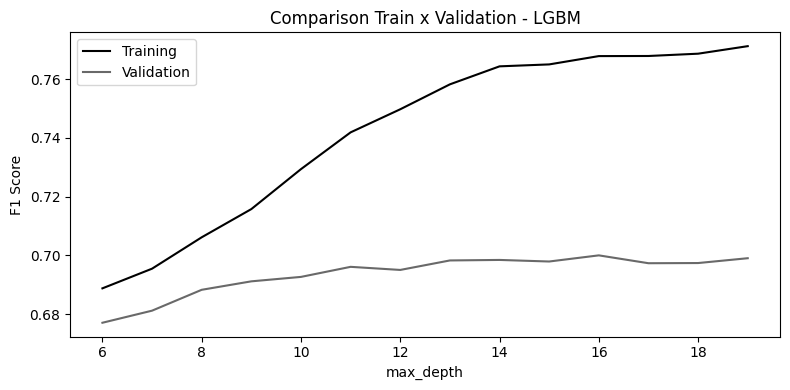

In [15]:
aux = lgbm_best_params
aux.pop('max_depth', None)

param_range = np.arange(6, 20, 1)

train_scores = [ ]
val_scores = [ ]
for i in param_range:
    lgbm = LGBMClassifier(**aux, max_depth = i)
    lgbm.fit(X_train,y_train)
    train_scores.append(f1_score(y_train,lgbm.predict(X_train)))
    val_scores.append(f1_score(y_val,lgbm.predict(X_val)))
    
plt.figure(figsize=(8,4))
plt.plot(param_range, train_scores, label="Training", color="black")
plt.plot(param_range, val_scores, label="Validation", color="dimgrey")
 
plt.title("Comparison Train x Validation - LGBM")
plt.xlabel("max_depth")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc="best");

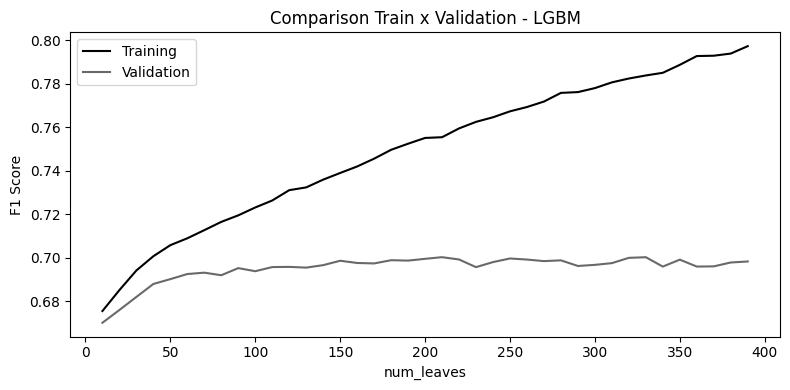

In [16]:
aux = lgbm_best_params.copy()
aux.pop('num_leaves', None)

param_range = np.arange(10, 400, 10)

train_scores = [ ]
val_scores = [ ]
for i in param_range:
    lgbm = LGBMClassifier(**aux, num_leaves = i)
    lgbm.fit(X_train,y_train)
    train_scores.append(f1_score(y_train,lgbm.predict(X_train)))
    val_scores.append(f1_score(y_val,lgbm.predict(X_val)))
    
plt.figure(figsize=(8,4))
plt.plot(param_range, train_scores, label="Training", color="black")
plt.plot(param_range, val_scores, label="Validation", color="dimgrey")
 
plt.title("Comparison Train x Validation - LGBM")
plt.xlabel("num_leaves")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc="best");

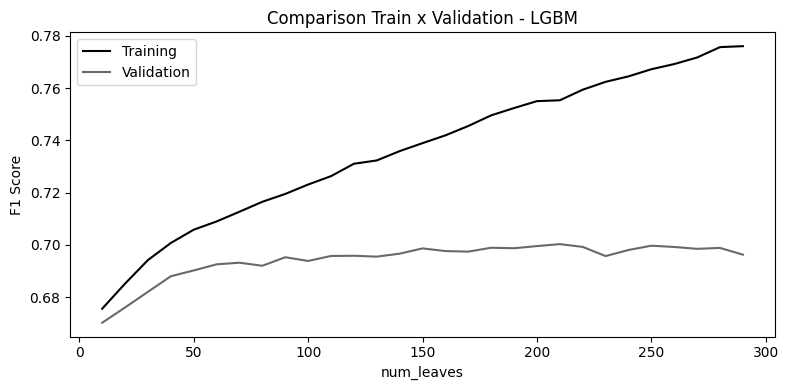

In [17]:
aux = lgbm_best_params.copy()
aux.pop('num_leaves', None)

param_range = np.arange(10, 300, 10)

train_scores = [ ]
val_scores = [ ]
for i in param_range:
    lgbm = LGBMClassifier(**aux, num_leaves = i)
    lgbm.fit(X_train,y_train)
    train_scores.append(f1_score(y_train,lgbm.predict(X_train)))
    val_scores.append(f1_score(y_val,lgbm.predict(X_val)))
    
plt.figure(figsize=(8,4))
plt.plot(param_range, train_scores, label="Training", color="black")
plt.plot(param_range, val_scores, label="Validation", color="dimgrey")
 
plt.title("Comparison Train x Validation - LGBM")
plt.xlabel("num_leaves")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc="best");

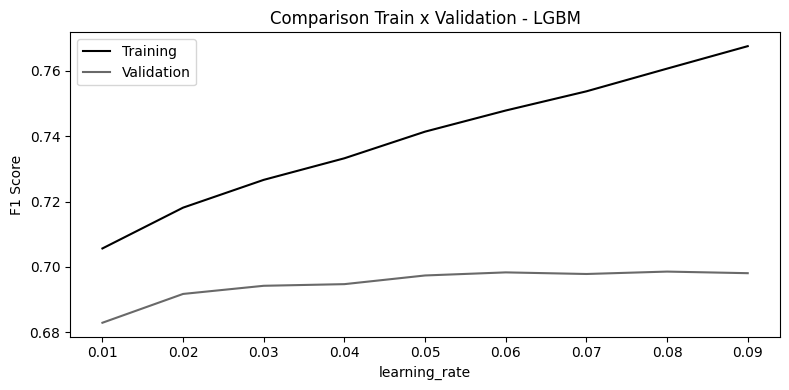

In [33]:
aux = lgbm_best_params.copy()
aux.pop('learning_rate', None)

param_range = np.arange(0.01, 0.1, 0.01)

train_scores = [ ]
val_scores = [ ]
for i in param_range:
    lgbm = LGBMClassifier(**aux, learning_rate = i)
    lgbm.fit(X_train,y_train)
    train_scores.append(f1_score(y_train,lgbm.predict(X_train)))
    val_scores.append(f1_score(y_val,lgbm.predict(X_val)))
    
plt.figure(figsize=(8,4))
plt.plot(param_range, train_scores, label="Training", color="black")
plt.plot(param_range, val_scores, label="Validation", color="dimgrey")
 
plt.title("Comparison Train x Validation - LGBM")
plt.xlabel("learning_rate")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc="best");

In [34]:
lgbm_best_params

{'objective': 'binary',
 'boosting_type': 'gbdt',
 'num_leaves': 280,
 'max_depth': 15,
 'learning_rate': 0.08751989227006869,
 'reg_alpha': 1.2347501942986178e-06,
 'reg_lambda': 0.9572197113568942,
 'subsample_freq': 2,
 'min_child_samples': 6,
 'scale_pos_weight': 2.631}

In [35]:
 lgbm_best_params_revised = {'objective': 'binary', 
                             'boosting_type': 'gbdt', 
                             'num_leaves': 200, 
                             'max_depth': 12, 
                             'learning_rate': 0.075, 
                             'reg_alpha': 0.0020, 
                             'reg_lambda': 0.25, 
                             'subsample_freq': 2, 
                             'min_child_samples': 1, 
                             'scale_pos_weight': 2.631}

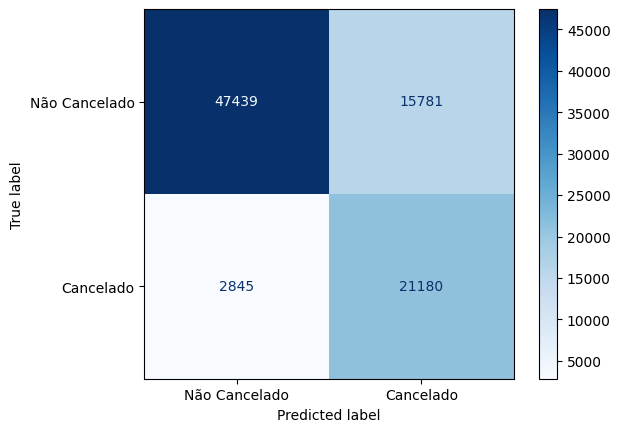

Score: 
               precision    recall  f1-score   support

           0       0.94      0.75      0.84     63220
           1       0.57      0.88      0.69     24025

    accuracy                           0.79     87245
   macro avg       0.76      0.82      0.77     87245
weighted avg       0.84      0.79      0.80     87245



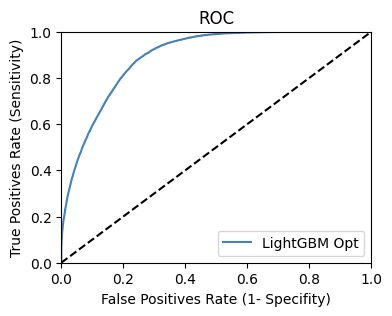

,value,std
fit_time,0.527380,0.046796
score_time,0.046667,0.003881
test_accuracy,0.786509,0.001330
train_accuracy,0.818225,0.001705
test_precision,0.573050,0.002049
train_precision,0.610586,0.002483
test_recall,0.881582,0.004569
train_recall,0.938418,0.000793
test_f1,0.694585,0.001255
train_f1,0.739807,0.001810


In [36]:
model_lgbm_tuned = LGBMClassifier(**lgbm_best_params_revised)
y_prob_lgbm_tuned, y_pred_lgbm_tuned = CVS(model_lgbm_tuned,X,y,'LightGBM Opt')

In [37]:
results = data.copy()
results['lgbm_prob'] = y_prob_lgbm_tuned
results['lgbm_pred'] = y_pred_lgbm_tuned
results

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,total_of_special_requests,reservation_status,reservation_status_date,people,kids,days_stay,country_name,continentes,lgbm_prob,lgbm_pred
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,Check-Out,2015-07-01,2.0,0.0,0,Portugal,Native,0.258218,0.0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0,Check-Out,2015-07-01,2.0,0.0,0,Portugal,Native,0.305957,0.0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,Check-Out,2015-07-02,1.0,0.0,1,United Kingdom,Europe,0.022102,0.0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,Check-Out,2015-07-02,1.0,0.0,1,United Kingdom,Europe,0.047155,0.0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,1,Check-Out,2015-07-03,2.0,0.0,2,United Kingdom,Europe,0.026855,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87240,City Hotel,0,23,2017,August,35,30,2,5,2,...,0,Check-Out,2017-09-06,2.0,0.0,7,Belgium,Europe,0.006514,0.0
87241,City Hotel,0,102,2017,August,35,31,2,5,3,...,2,Check-Out,2017-09-07,3.0,0.0,7,France,Europe,0.845938,1.0
87242,City Hotel,0,34,2017,August,35,31,2,5,2,...,4,Check-Out,2017-09-07,2.0,0.0,7,Germany,Europe,0.661274,1.0
87243,City Hotel,0,109,2017,August,35,31,2,5,2,...,0,Check-Out,2017-09-07,2.0,0.0,7,United Kingdom,Europe,0.038160,0.0


In [38]:
path = "/home/alysson/projects/Hotel-Booking-Cancelations/models/lgbm/"
filename = "lgbm_" + str(datetime.now().strftime("%d-%m-%y")) + str(".pkl")
filepath = str(path) + str(filename)

In [39]:
with open(filepath, 'wb') as file:
    pickle.dump(model_lgbm_tuned, file)